## Navier-Stokes Equations
$$
\nabla \overrightarrow{V} = 0
$$
$$
\rho \frac{D\overrightarrow{V}}{Dt} = -\nabla p + \rho \overrightarrow{g} + \mu \nabla^2 \overrightarrow{V}
$$

The Navier-Stokes equations describe the flow of fluids, relating changes in the velocity and pressure fields. Traditional 'solvers' use iterative numeric methods to solve for the velocity and pressure fields at each time step.

In two dimensions, the velocity field is a $W * H * 2$ tensor, where $W$ and $H$ are the width and height of the fluid domain and the last dimension holds the two components of the velocity vector. The equations generalize to any dimensions, but only really make sense in up to three dimensions.

## Simplicial Neural Networks
Simplicial neural networks (SNNs) are similar to graph neural network but also pass messages between higher order topological structures, or *simplexes*. 

![Any text here](simplex.png)

They allow representation of higher oreder interactions between nodes. For example, a 2-simplex (triangle) could represent three people live in the same home, as opposed to saying each pair of people live together.


## Problem Statement
The goal of this lab is to leverage SNNs to predict the next frame (i.e. velocity field) of a fluid. We compare our SNN against a Graph Neural Network (GNN) as a baseline.

## Dataset
We generated our own dataset using the FluidSim python library. This library includes solvers for several types of fluid simulation. We used the 2D Navier Stokes (`fluidsim.solvers.ns2d`), which solved the Navier-Stokes equations with a pseudo-spectral method.

## Parameters
The dataset was generated with the following parameters:
- **Domain Dimensions:** 32x32 grid
- **Input Field:** randomly generated velocity field, length: [0,5)
- **Input Forces:** none (closed system)
- **Number of Scenes:** 1000
- **Steps simulated per scene:** 5

In addition to calculating the velocity vector for each grid cell, FluidSim also calculates the rotation, a scalar describing how much the fluid in the cell is rotating. Each time step in the dataset is a grid of x velocity, y velocity, and rotation field values.

Note: Generating the dataset took about ~25 minutes. Uncompressed, it's about 2.5 gigabytes.

## FluidSim Example Animation
![Any text here](animation.gif)

## Example Data
Here are two scenes from our dataset. Scene inputs have varying amounts of 'smoothness' which is governed by the `params.init_fields.noise.length` field in FluidSim. We selected random lengths between 0 and 5.


<img src="velocity_animation_0.gif" width="60%">
<img src="velocity_animation_2.gif" width="60%">

# Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *

In [2]:
# load the data into a dataframe
df = pd.read_feather('velocity_fields_all_times.feather')
# df = pd.read_csv('velocity_fields_all_times.csv')
# convert to an ndarray of shape (scene, t, x, y, features)
df_idx = df.set_index(['scene','t','x','y'])
del(df) # delete intermediates to save memory
df_xr = df_idx.to_xarray()
del(df_idx)
np_data = df_xr.to_dataarray().to_numpy()
del(df_xr)
np_data = np.moveaxis(np_data, 0, -1)
np_data = np_data[:,:,:,:,:2]
print(np_data.shape)

(1000, 6, 32, 32, 2)


## Task 1: Constructing GNNs & SCNNs for computing total energy

In [3]:
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from toponetx.transform import graph_to_clique_complex
from utils import grid_to_graph, visualize_energy

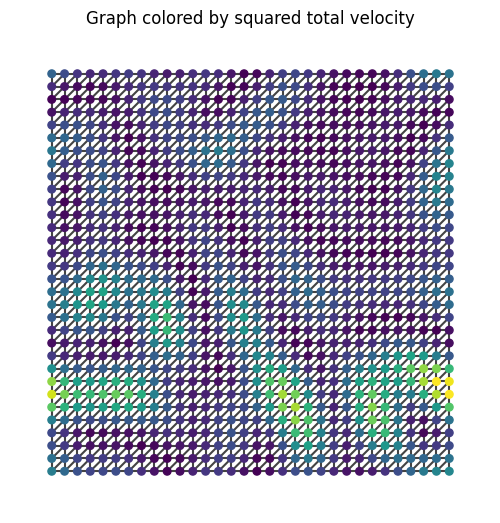

In [4]:
graph, coords_to_node, node_to_coords = grid_to_graph(np_data[0,0])
complex = graph_to_clique_complex(graph)
energies = np.sum(np_data[0,0,:,:,:]**2, axis=2)
visualize_energy(graph, energies, node_to_coords)

In [5]:
import torch
from models import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
torch_data = torch.tensor(np_data).float().to(device)
torch_data = torch_data.flatten(0,1)
torch_targets = torch.square(torch_data).sum(dim=(1,2,3))
edge_index = from_networkx(graph).edge_index.to(device)

perm = torch.randperm(torch_data.shape[0])
train_idx, test_idx = perm[:int(.9*len(perm))], perm[int(.9*len(perm)):]
train_inputs, train_targets, test_inputs, test_targets = torch_data[train_idx].flatten(1,2), torch_targets[train_idx], torch_data[test_idx].flatten(1,2), torch_targets[test_idx]

c:\Users\caleb\Python\torch_template\Lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  data_dict[key] = torch.as_tensor(value)


In [7]:
model = GCN(2, 32, 1, num_layers=3, graph_lev=True).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [ ]:
batch_size = 64

train_ds = torch.utils.data.TensorDataset(train_inputs, train_targets)
test_ds  = torch.utils.data.TensorDataset(test_inputs, test_targets)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

eval_every = 200
patience, patience_counter = 10, 0
best_loss = float('inf')
best_state = None

for step in tqdm(range(5000)):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb, edge_index)
        loss = criterion(out.squeeze(), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach()

    if step % eval_every == 0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                test_out = model(xb, edge_index)
                test_loss += criterion(test_out.squeeze(), yb)

        test_loss = test_loss / len(test_loader)
        train_loss = total_loss / len(train_loader)

        if test_loss < best_loss:
            best_loss = test_loss
            best_state = {k: v.detach().cpu().clone()
                          for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        print(f"step {step}, train {train_loss:.4f}, test {test_loss:.4f}")

        if patience_counter >= patience:
            print("early stopping")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, "best_model.pt")
    print("Best model saved.")


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0, train 36918.7266, test 36067.3281


KeyboardInterrupt: 

# Baseline Training: MLP

In [21]:
N = np_data.shape[0]
train_idx, test_idx = torch.utils.data.random_split(range(N), [int(0.9*N), N - int(0.9*N)])

## Baseline: Train a small MLP

In [35]:
# Appropriately define data for an MLP
train_data = torch.tensor(np_data[train_idx,0,:,:,:]).to(device).float()
train_targets = torch.tensor(np_data[train_idx,1,:,:,:]).to(device).float()
val_data = torch.tensor(np_data[test_idx,0,:,:,:]).to(device).float()
val_targets = torch.tensor(np_data[test_idx,1,:,:,:]).to(device).float()
train_data, train_targets, val_data, val_targets = [t.flatten(start_dim=1) for t in (train_data, train_targets, val_data, val_targets)]

In [36]:
# Choose model, loss function, optimizer
model = MLP(train_data.shape[1], 16, train_data.shape[1], num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
sum(p.numel() for p in model.parameters() if p.requires_grad)

67600

In [37]:
# Training loop
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(100000)):
    optimizer.zero_grad()
    y_pred = model(train_data)
    loss = criterion(y_pred, train_targets)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        with torch.no_grad():
            y_identity = val_data
            loss_mlp = criterion(model(val_data), val_targets).item()

            train_losses.append(loss.item())
            val_losses.append(loss_mlp)

            print(f"\nEpoch {epoch+1}:")
            print(f"  Train Loss: {loss.item():.6f}")
            print(f"  Val Loss (MLP): {loss_mlp:.6f}")

            if loss_mlp < best_val_loss:
                best_val_loss = loss_mlp
                best_model_state = model.state_dict().copy()
                torch.save(best_model_state, "best_model.pt")

  0%|          | 0/100000 [00:00<?, ?it/s]


Epoch 5000:
  Train Loss: 0.104945
  Val Loss (MLP): 0.102762

Epoch 10000:
  Train Loss: 0.098113
  Val Loss (MLP): 0.096116

Epoch 15000:
  Train Loss: 0.091905
  Val Loss (MLP): 0.090086

Epoch 20000:
  Train Loss: 0.086252
  Val Loss (MLP): 0.084605

Epoch 25000:
  Train Loss: 0.081098
  Val Loss (MLP): 0.079616

Epoch 30000:
  Train Loss: 0.076395
  Val Loss (MLP): 0.075073

Epoch 35000:
  Train Loss: 0.072099
  Val Loss (MLP): 0.070932

Epoch 40000:
  Train Loss: 0.068173
  Val Loss (MLP): 0.067157

Epoch 45000:
  Train Loss: 0.064583
  Val Loss (MLP): 0.063712

Epoch 50000:
  Train Loss: 0.061298
  Val Loss (MLP): 0.060568

Epoch 55000:
  Train Loss: 0.058290
  Val Loss (MLP): 0.057698

Epoch 60000:
  Train Loss: 0.055536
  Val Loss (MLP): 0.055078

Epoch 65000:
  Train Loss: 0.053012
  Val Loss (MLP): 0.052684

Epoch 70000:
  Train Loss: 0.050692
  Val Loss (MLP): 0.050491

Epoch 75000:
  Train Loss: 0.048573
  Val Loss (MLP): 0.048494

Epoch 80000:
  Train Loss: 0.046631
  Va

MSE of identity function: 0.009339
MSE of trained MLP:       0.040812
Relative improvement:     -0.031473


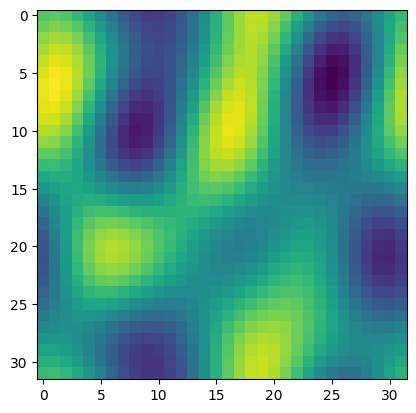

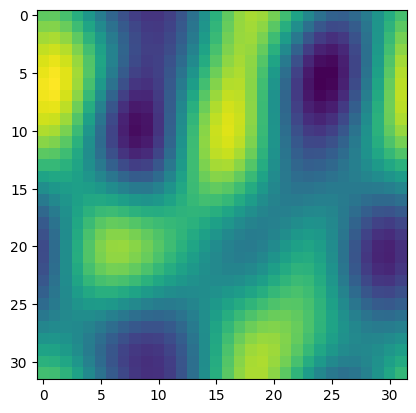

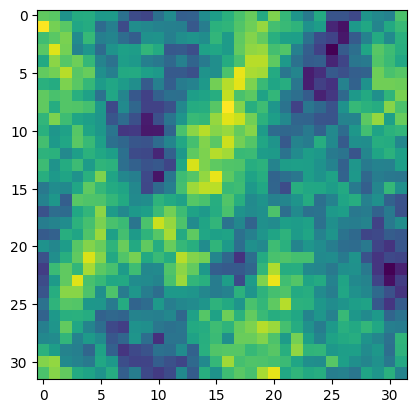

In [38]:
y_identity = val_data
loss_identity = criterion(y_identity, val_targets).item()

print(f"MSE of identity function: {loss_identity:.6f}")
print(f"MSE of trained MLP:       {loss_mlp:.6f}")
print(f"Relative improvement:     {(loss_identity - loss_mlp):.6f}")
plt.imshow(train_data[1].view(32,32,2).cpu().detach().numpy()[:,:,0])
plt.show()
plt.close()
plt.imshow(train_targets[1].view(32,32,2).cpu().detach().numpy()[:,:,0])
plt.show()
plt.close()
plt.imshow(model(train_data)[20].view(32,32,2).cpu().detach().numpy()[:,:,0]);

## Graph Convolutional Network

Starting


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
template_data = from_networkx(t0_reps[0].G)
edge_index = template_data.edge_index

train_graphs = [
    Data(
        x=torch.tensor(np_data[i, 0], dtype=torch.float).flatten(0,1),
        edge_index=edge_index,
        y=torch.tensor(np_data[i, -1], dtype=torch.float).flatten(0,1))
    for i in train_idx
]

test_graphs = [
    Data(
        x=torch.tensor(np_data[i, 0], dtype=torch.float).flatten(0,1),
        edge_index=edge_index,
        y=torch.tensor(np_data[i, -1], dtype=torch.float).flatten(0,1)
    )
    for i in test_idx
]


train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_graphs,  batch_size=32, shuffle=False)

c:\Users\caleb\Python\torch_template\Lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  data_dict[key] = torch.as_tensor(value)


In [11]:
model = GCN(2, 32, 2, num_layers=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
sum(p.numel() for p in model.parameters() if p.requires_grad)

1218

In [ ]:
best_val_loss = float("inf")
train_losses, val_losses = [], []

for epoch in tqdm(range(5000)):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        y_pred = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(y_pred, batch.y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # every 5000 steps — validation
    if (epoch + 1) % 50 == 0:
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                y_pred = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(y_pred, batch.y)
                total_val_loss += loss.item()

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)

        print(f"Epoch {epoch+1} | Train {total_train_loss:.6f} | Val {total_val_loss:.6f}")

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            torch.save(model.state_dict(), "best_model.pt")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 50 | Train 0.055722 | Val 0.060497
Epoch 100 | Train 0.055776 | Val 0.060049
Epoch 150 | Train 0.055878 | Val 0.059772
Epoch 200 | Train 0.055023 | Val 0.059579


KeyboardInterrupt: 

## Conclusion

Scenario 1:
Our SNN performs X% better than the GNN at predicting the next frame of a fluid flow. We attribute this to the higher order features it can represent, providing more information to the model.

Scenario 2:
Our SNN performs about the same as the GNN baseline. The 'higher order' features of our model are somewhat contrived, as they are constructed from a regular grid and do not encode any additional meaning about the actual fluid flow. A more dynamic topology, for example one based on velocity vectors and eddies, might perform better as it encodes relevant information about the fluid.

Scenario 3:
Our SNN performs worse than the GNN baseline. The 'higher order' features of our model are somewhat contrived, as they are constructed from a regular grid and do not encode any additional meaning about the actual fluid flow, so these additional features add noise to the model and lead to worse performance.

## Conclusions

1. While topological networks have the potential to capture meaningful higher-order relationships, they also impose additional computational constraints without providing benefits on simple tasks.

2. 